In [1]:
import numpy as np

import tensorflow as tf


from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator


In [2]:
import tensorflow as tf

print(tf.__version__)

2.14.0


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

# Custom preprocessing function for EfficientNet
def efficientnet_preprocessing(x):
    # Apply EfficientNet specific preprocessing, dose nothing is a placeholder
    x = preprocess_input(x)
    return x

# Image Data Generator for training data
train_data_gen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocessing, # Add custom preprocessing
    #rescale=1./255  # Rescaling is still fine here
)

# Image Data Generator for validation data
validation_data_gen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocessing, # Add custom preprocessing
    #rescale=1./255  # Rescaling is still fine here
)

#FAKE -> 0
#REAL -> 1

# Train generator
train_generator = train_data_gen.flow_from_directory(
    '../biometric_project/data/data_50K_2/train/',
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode="binary"
)

# Validation generator
validation_generator = validation_data_gen.flow_from_directory(
    '../biometric_project/data/data_50K_2/val/',
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode="binary"
)


Found 35064 images belonging to 2 classes.
Found 13897 images belonging to 2 classes.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Configuration for the model
num_classes = 1  # Assuming binary classification
input_shape = (224, 224, 3)  # Standard input size for EfficientNetB0

# Define the model
model = models.Sequential()

# Add the EfficientNet backbone
model.add(tf.keras.applications.EfficientNetB0(
    include_top=False,  # Do not include the built-in classification head
    input_shape=input_shape,
    pooling='avg',  # Add global average pooling to flatten the output
    weights='imagenet'  # Pre-trained weights on ImageNet
))

# Add the classification head
model.add(layers.Dense(num_classes, activation='sigmoid'))  

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4050852 (15.45 MB)
Trainable params: 4008829 (15.29 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


In [5]:
dummy_input = tf.random.uniform((1, 224, 224, 3))  # adjust the shape as necessary
model(dummy_input)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4050852 (15.45 MB)
Trainable params: 4008829 (15.29 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


In [6]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Define the ModelCheckpoint callback to save the best weights
#checkpoint = ModelCheckpoint('EfficientViT.h5', monitor='val_accuracy', save_best_only=True, mode='max')

checkpoint = ModelCheckpoint('backbone_head_5', monitor='val_accuracy', save_best_only=True, mode='max', save_format='tf')


In [7]:
# Train the model
model_info = model.fit(
    train_generator,
    steps_per_epoch= train_generator.n // 32,
    epochs = 6,
    validation_data = validation_generator,
    validation_steps= validation_generator.n // 32,
    callbacks=[reduce_lr, checkpoint]
)

Epoch 1/6
1095/1095 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.9588INFO:tensorflow:Assets written to: backbone_head_5\assets


INFO:tensorflow:Assets written to: backbone_head_5\assets


1095/1095 [==============================] - 6157s 6s/step - loss: 0.1031 - accuracy: 0.9588 - val_loss: 0.6502 - val_accuracy: 0.8476 - lr: 0.0010
Epoch 2/6
1095/1095 [==============================] - 6176s 6s/step - loss: 0.0470 - accuracy: 0.9814 - val_loss: 0.7223 - val_accuracy: 0.8178 - lr: 0.0010
Epoch 3/6
1095/1095 [==============================] - 6258s 6s/step - loss: 0.0327 - accuracy: 0.9883 - val_loss: 0.7421 - val_accuracy: 0.8303 - lr: 0.0010
Epoch 4/6
1095/1095 [==============================] - 6203s 6s/step - loss: 0.0178 - accuracy: 0.9940 - val_loss: 0.4518 - val_accuracy: 0.8420 - lr: 0.0010
Epoch 5/6
1095/1095 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9947INFO:tensorflow:Assets written to: backbone_head_5\assets


INFO:tensorflow:Assets written to: backbone_head_5\assets


1095/1095 [==============================] - 6325s 6s/step - loss: 0.0169 - accuracy: 0.9947 - val_loss: 0.5235 - val_accuracy: 0.8491 - lr: 0.0010
Epoch 6/6
1095/1095 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9957INFO:tensorflow:Assets written to: backbone_head_5\assets


INFO:tensorflow:Assets written to: backbone_head_5\assets


1095/1095 [==============================] - 6260s 6s/step - loss: 0.0134 - accuracy: 0.9957 - val_loss: 0.5506 - val_accuracy: 0.8617 - lr: 0.0010


In [8]:
#save model structure in json file
#model_json = model.to_json()
#with open("EfficientViT.json", "w") as json_file:
#    json_file.write(model_json)

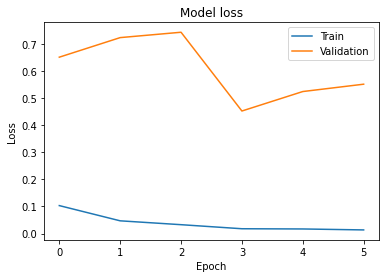

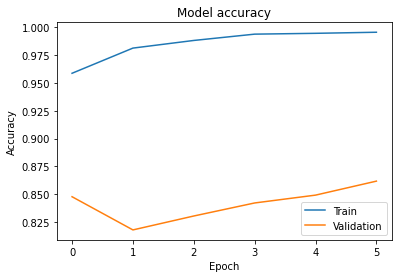

In [9]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(model_info.history['loss'])
plt.plot(model_info.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training and validation accuracy
plt.plot(model_info.history['accuracy'])
plt.plot(model_info.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [10]:
model = tf.keras.models.load_model('backbone_head_5')

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

# Custom preprocessing function for EfficientNet
def efficientnet_preprocessing(x):
    # Apply EfficientNet specific preprocessing
    x = preprocess_input(x)
    return x

# Image Data Generator for training data
train_data_gen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocessing, # Add custom preprocessing
    #rescale=1./255  # Rescaling is still fine here
)

# Image Data Generator for validation data
validation_data_gen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocessing, # Add custom preprocessing
    #rescale=1./255  # Rescaling is still fine here
)

# Train generator
train_generator = train_data_gen.flow_from_directory(
    '../biometric_project/data/data_50K_2/train/',
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode="binary",
    shuffle = False
)

# Validation generator
validation_generator = validation_data_gen.flow_from_directory(
    '../biometric_project/data/data_50K_2/val/',
    target_size=(224, 224),
    batch_size=32,
    color_mode="rgb",
    class_mode="binary",
    shuffle = False
)


Found 35064 images belonging to 2 classes.
Found 13897 images belonging to 2 classes.


<ipython-input-12-98cda6eb209b>:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(validation_generator)


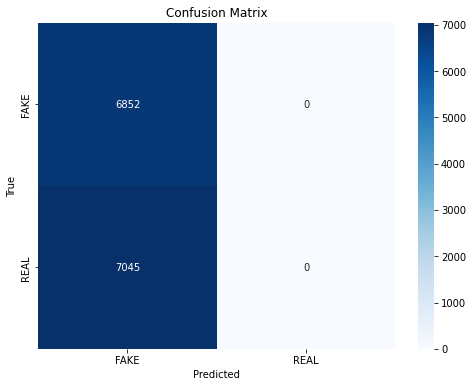

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


predictions = model.predict_generator(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

confusion_mtx = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [13]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_classes, predicted_classes)
print("Accuracy:", accuracy)

Accuracy: 0.493056055263726


<ipython-input-14-ad5b78e601eb>:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(train_generator)


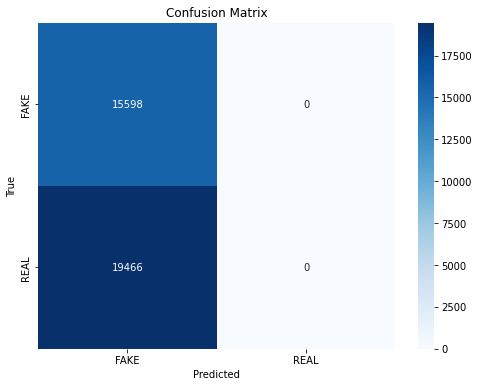

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


predictions = model.predict_generator(train_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = train_generator.classes
class_labels = list(train_generator.class_indices.keys())

confusion_mtx = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_classes, predicted_classes)
print("Accuracy:", accuracy)

Accuracy: 0.4448437143509012


In [16]:
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

435/435 [==============================] - 459s 1s/step - loss: 0.5508 - accuracy: 0.8616
Validation Loss: 0.5508272051811218
Validation Accuracy: 0.8616248369216919


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
num_of_test_samples = validation_generator.n 
batch_size = 32

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['FAKE','REAL']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

<ipython-input-17-4b0e8a04a1e5>:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)


Confusion Matrix
[[6852    0]
 [7045    0]]
Classification Report
              precision    recall  f1-score   support

        FAKE       0.49      1.00      0.66      6852
        REAL       0.00      0.00      0.00      7045

    accuracy                           0.49     13897
   macro avg       0.25      0.50      0.33     13897
weighted avg       0.24      0.49      0.33     13897



d:\SHREY\Others\python3_9_4\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\SHREY\Others\python3_9_4\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\SHREY\Others\python3_9_4\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
num_of_train_samples = train_generator.n
batch_size = 32

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(train_generator, num_of_train_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(train_generator.classes, y_pred))
print('Classification Report')
target_names = ['FAKE','REAL']
print(classification_report(train_generator.classes, y_pred, target_names=target_names))


<ipython-input-18-32d1fd546e9f>:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(train_generator, num_of_train_samples // batch_size+1)


Confusion Matrix
[[15598     0]
 [19466     0]]
Classification Report
              precision    recall  f1-score   support

        FAKE       0.44      1.00      0.62     15598
        REAL       0.00      0.00      0.00     19466

    accuracy                           0.44     35064
   macro avg       0.22      0.50      0.31     35064
weighted avg       0.20      0.44      0.27     35064



d:\SHREY\Others\python3_9_4\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\SHREY\Others\python3_9_4\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\SHREY\Others\python3_9_4\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
